# FIG4 (second half)
## Real space segmentation for scan 13
 - Use the HAADF signal to determine particle locations

In [1]:
#%matplotlib widget

from pathlib import Path

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import FancyArrowPatch
import ncempy

from scipy import ndimage
from scipy.optimize import curve_fit

import stempy.io as stio
import stempy.image as stim

# Better viridis
import matplotlib
viridis2 = matplotlib.colormaps['viridis']
viridis2.set_bad(viridis2.get_under())

distiller_path = Path('/global/cfs/cdirs/ncemhub/distiller')

Probe step size = 0.001150223077274859 µm


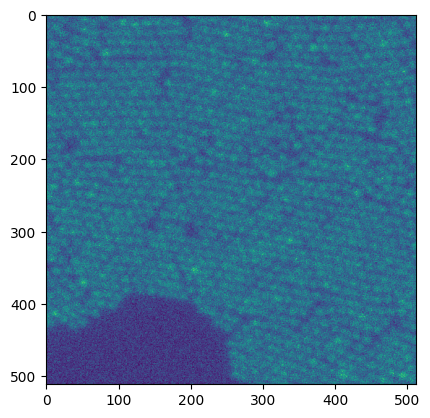

In [2]:
# Load the HAADF image for scan 13
haadf_path = Path('/global/cfs/cdirs/ncemhub/jrenner1/final/data/scan13.dm4')

haadf = ncempy.read(haadf_path)

fg,ax = plt.subplots(1,1)
ax.imshow(haadf['data'])

print(f'Probe step size = {haadf["pixelSize"][0]} {haadf["pixelUnit"][0]}')

In [3]:
# Function to mask in real space [x0 - radius, x0 + radius+1] in x; [y0 - radius, y0 + radius+1] with weights
def mask_real_space_weighted(all_frames, all_weights, frame_shape, scan_shape, x0, y0, radius):
    
    # Set up a blank diffraction pattern
    dp_weighted_particle = np.zeros(frame_shape[0]*frame_shape[1], np.uint32)
    
    # Set up the real space selection ranges
    rng_x = [x0 - radius, x0 + radius + 1]
    rng_y = [y0 - radius, y0 + radius + 1]
    
    # Loop through all frames to get the corresponding weighted counts
    for ii, (events, weights) in enumerate(zip(frames_gausscount, weights_gausscount)):
        x = (ii // scan_shape[1])
        y = (ii % scan_shape[1])
        if(x >= rng_x[0] and x < rng_x[1] and y >= rng_y[0] and y < rng_y[1]): # select the region in real space
            if(np.sqrt((x - x0)**2 + (y - y0)**2) < radius):  # apply the mask 
                dp_weighted_particle[events] += weights
                
    # Reshape to a 2D array.
    dp_weighted_particle = dp_weighted_particle.reshape(frame_shape)
    
    return dp_weighted_particle

In [4]:
counted_file_standard = "/global/cfs/cdirs/ncemhub/jrenner1/scan13/FOURD_241025_1449_20713_00013_centered.h5"
counted_file_gausscount = "/global/cfs/cdirs/ncemhub/jrenner1/scan13/counted_gauss_prior_scan0000000013_centered.h5"

# Load the 4D Camera data as a sparse array
sp_path = Path(counted_file_standard)
sp = stio.load_electron_counts(sp_path)

# Load the new counted data with weights
with h5py.File(counted_file_gausscount, 'r') as f0:
    frames_gausscount = f0['electron_events/frames'][:]
    weights_gausscount = f0['electron_events/weights'][:]
    frame_shape_gausscount = (f0['electron_events']['frames'].attrs['Ny'],f0['electron_events']['frames'].attrs['Nx'])
    scan_shape_gausscount = (f0['electron_events']['scan_positions'].attrs['Ny'],f0['electron_events']['scan_positions'].attrs['Nx'])

[Text(0.5, 1.0, 'HAADF with NP centers')]

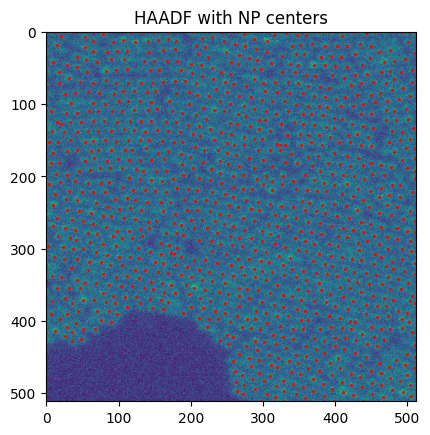

In [5]:
haadf_filtered = ndimage.gaussian_filter(haadf['data'].astype(np.float32), 3) # ensure float type

# Find NP centers based on the smoothed data
peaks = ncempy.algo.peak_find.peakFind2D(haadf_filtered, 0.995)

fg,ax = plt.subplots(1, 1)
ax.imshow(haadf['data'])
ax.scatter(peaks[:,1], peaks[:,0], c='r', marker='x', s=2)
ax.set(title='HAADF with NP centers')

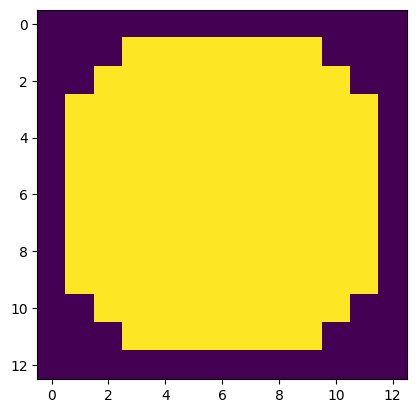

In [6]:
# Create a circular mask the size of each nanoparticle
radius = 6
box_size = 13

YY, XX = np.mgrid[0:box_size, 0:box_size]
RR = np.sqrt((YY - (box_size-1)/2)**2 + (XX - (box_size-1)/2)**2)

mask = np.where(RR < radius, 1, 0)

plt.figure()
plt.imshow(mask)


In [7]:
# Cut in real space on the region around every NP
edge = []
sh = haadf['data'].shape
r = (box_size-1)/2
dps = np.zeros((peaks.shape[0], sp.shape[2], sp.shape[3]))
dps_weights = np.zeros((peaks.shape[0], sp.shape[2], sp.shape[3]))
good_dps = []
#print(f"Frame shape is {sp.frame_shape}; scan shape is {sp.scan_shape}")

for ii, (x, y) in enumerate(peaks):
    if x >= r and x <= sh[0] - r - 1 and y >= r and y <= sh[1] - r - 1:
        # Ignore NPs at the edge
        try:
            if(ii % int(len(peaks)/10) == 0): print(f"Processing diffraction pattern {ii}")

            # Get the diffraction pattern for this peak
            sp_crop = sp[x-radius:x+radius+1, y-radius:y+radius+1, :, :]
            dps[ii, :, :] = stim.mask_real_space(sp_crop, mask)
            
            # Do the same thing but for the weighted counts
            dps_weights[ii, :, :] = mask_real_space_weighted(frames_gausscount, weights_gausscount, frame_shape_gausscount, scan_shape_gausscount, x, y, radius)
            
            good_dps.append(ii)
        except:
            raise
    else:
        edge.append((x, y)) # log NP locations that are too close to the edge

Processing diffraction pattern 103
Processing diffraction pattern 206
Processing diffraction pattern 309
Processing diffraction pattern 412
Processing diffraction pattern 515
Processing diffraction pattern 618
Processing diffraction pattern 721
Processing diffraction pattern 824
Processing diffraction pattern 927


Examining pattern 30


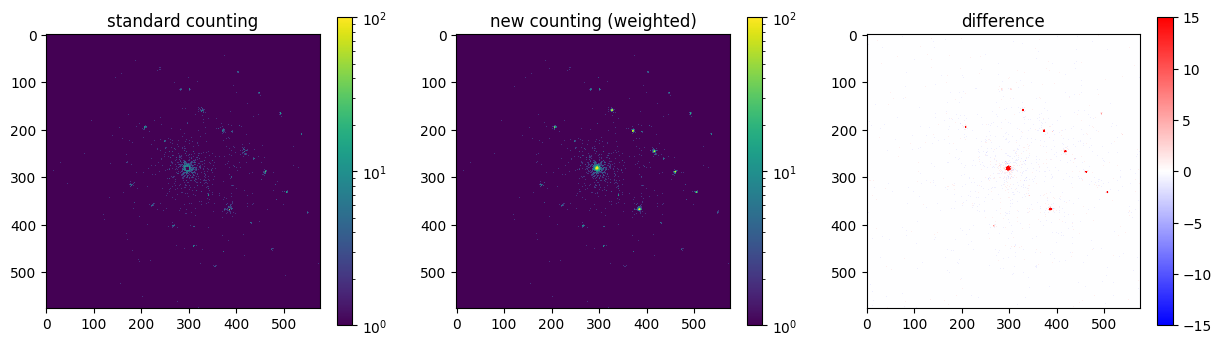

(array([  0,   1,   2, ..., 574, 574, 574]), array([309,  60,  45, ...,  43, 104, 285]))


In [8]:
# Check that the two dps arrays match (if testing the mask_real_space_weighted function with no weights)
# print((dps == dps_weights).all())

norm_bwr = Normalize(-15, 15)

# Compare a frame between unweighted and weighted
idps = good_dps[5]
print(f"Examining pattern {idps}")
fg,ax = plt.subplots(1, 3, figsize=(15,4))
img0 = ax[0].imshow(dps[idps], norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none")
ax[0].set_title("standard counting")
fg.colorbar(img0, ax=ax[0])
img1 = ax[1].imshow(dps_weights[idps], norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none")
ax[1].set_title("new counting (weighted)")
fg.colorbar(img1, ax=ax[1])
img2 = ax[2].imshow(dps_weights[idps] - dps[idps], cmap='bwr', interpolation="none", norm=norm_bwr)
ax[2].set_title("difference")
fg.colorbar(img2, ax=ax[2])
plt.show()
print(np.nonzero(dps_weights[idps] - dps[idps]))

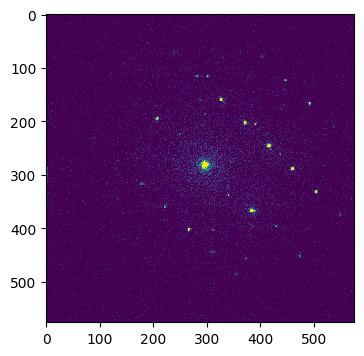

In [9]:
fg,ax = plt.subplots(1, 1, figsize=(4,4))
plt.imshow(dps_weights[idps], vmax=10, cmap=viridis2, interpolation="none")
plt.show()

In [10]:
#ncempy.viz.stack_view(dps, norm=LogNorm(), cmap=viridis2)

In [12]:
def fit_common_peaks(dps1, dps2, good_dps, threshold=7, min_dist=10, peak_window=5):
    """
    Finds and fits peaks common to two lists of diffraction patterns.

    Args:
    - dps1 (array): First list of diffraction patterns.
    - dps2 (array): Second list of diffraction patterns.
    - good_dps (list): Indices of diffraction patterns to process.
    - threshold (float): Threshold for peak finding.
    - min_dist (int): Minimum distance between peaks.
    - peak_window (int): Size of the window to fit peaks.

    Returns:
    - results1 (dict): Dictionary containing sigma_x, sigma_y, and intensity from fits to dps1.
    - results2 (dict): Dictionary containing sigma_x, sigma_y, and intensity from fits to dps2.
    """
    sigma_x_all_1, sigma_y_all_1, intensity_all_1 = [], [], []
    sigma_x_all_2, sigma_y_all_2, intensity_all_2 = [], [], []
    
    # Range for filtering peaks near zero-point
    x_range_zp = [275, 325]
    y_range_zp = [275, 325]

    for ii,idx in enumerate(good_dps):
        
        if(ii % int(len(good_dps)/10) == 0): print(f"On pattern {ii} of {len(good_dps)}")
        
        # Process the first set of diffraction patterns
        dp1 = dps1[idx, :, :] + np.random.rand(576, 576) / 100000  # Add a small amount of noise
        dp1_peaks = ncempy.algo.peak_find.peakFind2D(dp1, threshold / dp1.max())
        dp1_peaks = ncempy.algo.peak_find.enforceMinDist(dp1_peaks, dp1[dp1_peaks[:, 0], dp1_peaks[:, 1]], min_dist)        
        # Filter peaks near the zero-point
        dp1_peaks = np.array([peak for peak in dp1_peaks if not (x_range_zp[0] <= peak[1] <= x_range_zp[1] and y_range_zp[0] <= peak[0] <= y_range_zp[1])])

        # Process the second set of diffraction patterns
        dp2 = dps2[idx, :, :] + np.random.rand(576, 576) / 100000  # Add a small amount of noise
        dp2_peaks = ncempy.algo.peak_find.peakFind2D(dp2, threshold / dp2.max())
        dp2_peaks = ncempy.algo.peak_find.enforceMinDist(dp2_peaks, dp2[dp2_peaks[:, 0], dp2_peaks[:, 1]], min_dist)
        # Filter peaks near the zero-point
        dp2_peaks = np.array([peak for peak in dp2_peaks if not (x_range_zp[0] <= peak[1] <= x_range_zp[1] and y_range_zp[0] <= peak[0] <= y_range_zp[1])])
        
        # Find common peaks based on their locations
        common_peaks = []
        for peak in dp1_peaks:
            if any(np.linalg.norm(peak - p2) < min_dist for p2 in dp2_peaks):
                common_peaks.append(peak)
        common_peaks = np.array(common_peaks)
        #print(f"From ({len(dp1_peaks)}, {len(dp2_peaks)}) found {len(common_peaks)} common peaks") #: {common_peaks}")

        # Fit common peaks
        if(len(common_peaks) > 0):
            try:
                # First perform all fits, so that if one fails we won't fill any arrays.
                fits1 = ncempy.algo.peak_find.fit_peaks_gauss2d(dps1[idx, :, :].astype(np.float32), common_peaks, peak_window, (1, 1), ((-2, -2, 0, 0), (2, 2, 5, 5)))
                fits2 = ncempy.algo.peak_find.fit_peaks_gauss2d(dps2[idx, :, :].astype(np.float32), common_peaks, peak_window, (1, 1), ((-2, -2, 0, 0), (2, 2, 5, 5)))

                for sigma_x, sigma_y, intensity in zip(fits1[2][:, 2], fits1[2][:, 3], fits1[1]):
                    sigma_x_all_1.append(sigma_x)
                    sigma_y_all_1.append(sigma_y)
                    intensity_all_1.append(intensity)
                for sigma_x, sigma_y, intensity in zip(fits2[2][:, 2], fits2[2][:, 3], fits2[1]):
                    sigma_x_all_2.append(sigma_x)
                    sigma_y_all_2.append(sigma_y)
                    intensity_all_2.append(intensity)
            except:
                print(f"Warning: fit_peaks_gauss2d failed for diffraction pattern {idx}")

    # Prepare results as dictionaries
    results1 = {'sigma_x': sigma_x_all_1, 'sigma_y': sigma_y_all_1, 'intensity': intensity_all_1}
    results2 = {'sigma_x': sigma_x_all_2, 'sigma_y': sigma_y_all_2, 'intensity': intensity_all_2}

    return results1, results2

In [13]:
results_standard,results_weights = fit_common_peaks(dps, dps_weights, good_dps, threshold=12, min_dist=2, peak_window=5)

On pattern 0 of 969
On pattern 96 of 969
On pattern 192 of 969
On pattern 288 of 969
On pattern 384 of 969
On pattern 480 of 969
On pattern 576 of 969
On pattern 672 of 969
On pattern 768 of 969
On pattern 864 of 969
On pattern 960 of 969


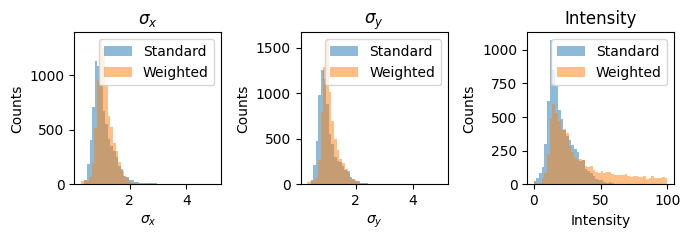

7725 peaks in standard; 7725 in new


In [15]:
# Extract values from the results dictionaries
sigma_x_standard = np.array(results_standard['sigma_x'])
sigma_y_standard = np.array(results_standard['sigma_y'])
intensity_standard = np.array(results_standard['intensity'])

sigma_x_weights = np.array(results_weights['sigma_x'])
sigma_y_weights = np.array(results_weights['sigma_y'])
intensity_weights = np.array(results_weights['intensity'])

# Create histograms for the extracted values
fg, ax = plt.subplots(1, 3, figsize=(7, 2.5))

# Histogram for sigma_x
ax[0].hist(sigma_x_standard, bins=50, alpha=0.5, label="Standard")
ax[0].hist(sigma_x_weights, bins=50, alpha=0.5, label="Weighted")
ax[0].set_title("$\sigma_x$")
ax[0].set_xlabel("$\sigma_x$")
ax[0].set_ylabel("Counts")
ax[0].legend()

# Histogram for sigma_y
ax[1].hist(sigma_y_standard, bins=50, alpha=0.5, label="Standard")
ax[1].hist(sigma_y_weights, bins=50, alpha=0.5, label="Weighted")
ax[1].set_title("$\sigma_y$")
ax[1].set_xlabel("$\sigma_y$")
ax[1].set_ylabel("Counts")
ax[1].legend()

# Histogram for intensity
ax[2].hist(intensity_standard, bins=50, alpha=0.5, label="Standard", range=[0, 100])
ax[2].hist(intensity_weights, bins=50, alpha=0.5, label="Weighted", range=[0, 100])
ax[2].set_title("Intensity")
ax[2].set_xlabel("Intensity")
ax[2].set_ylabel("Counts")
ax[2].legend()

plt.tight_layout()
plt.show()

print(f"{len(sigma_x_standard)} peaks in standard; {len(sigma_x_weights)} in new")

0.9320388349514563


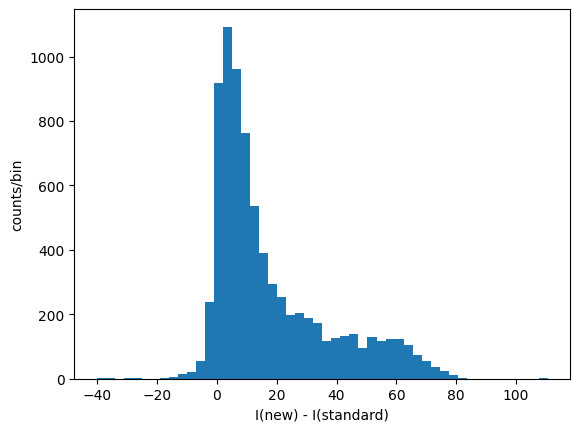

In [16]:
# peak intensity comparisons
cuts = (sigma_x_standard  > 0.) & (sigma_x_standard < 5) & \
        (sigma_y_standard > 0.) & (sigma_y_standard < 5) & \
        (sigma_x_weights  > 0.) & (sigma_x_weights  < 5) & \
        (sigma_y_weights  > 0.) & (sigma_y_weights  < 5)
fg,ax = plt.subplots(1,1)
intensity_diff = intensity_weights[cuts]-intensity_standard[cuts]
plt.hist(intensity_diff,bins=50) #,range=[-20,100])
plt.xlabel("I(new) - I(standard)")
plt.ylabel("counts/bin")
print(f"{len(intensity_diff[intensity_diff > 0])/len(intensity_diff)}")

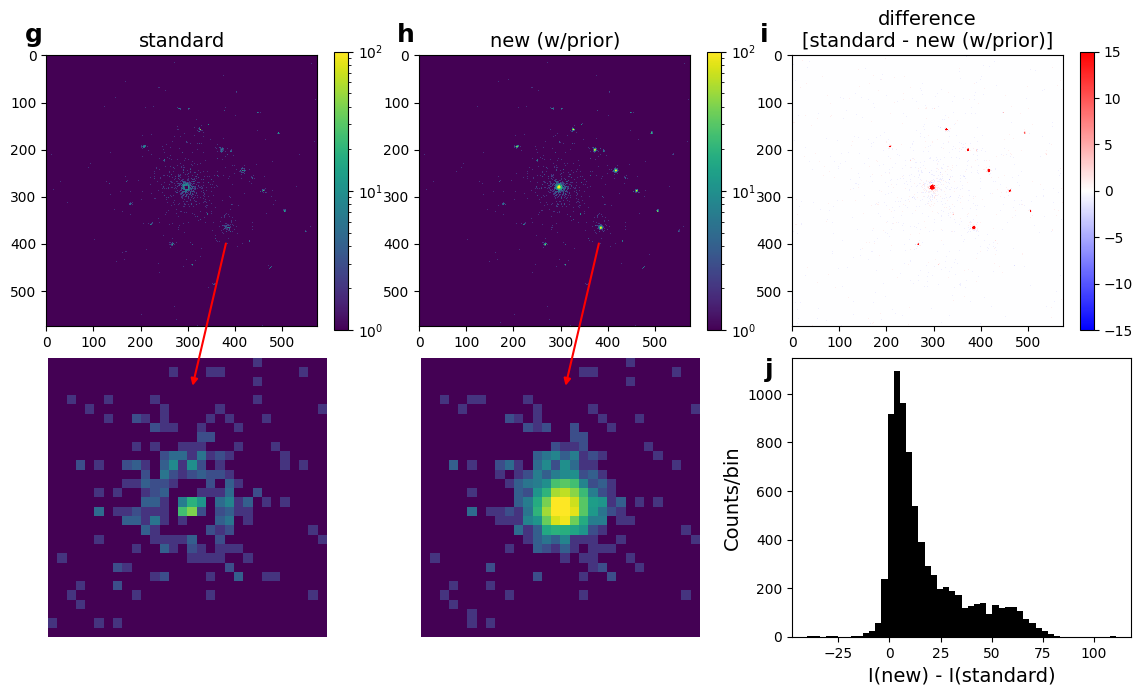

In [23]:
# Main figure

# ROW 1: Diffraction patterns (standard counting, new counting)
idps = good_dps[5]
norm_bwr = Normalize(-15, 15)
standard_dp = dps[idps]
weighted_dp = dps_weights[idps]
difference_dp = dps_weights[idps] - dps[idps]

# ROW 2 LEFT: Intensities histogram
cuts = (sigma_x_standard > 0.) & (sigma_x_standard < 5) & \
       (sigma_y_standard > 0.) & (sigma_y_standard < 5) & \
       (sigma_x_weights > 0.) & (sigma_x_weights < 5) & \
       (sigma_y_weights > 0.) & (sigma_y_weights < 5)
intensity_diff = intensity_weights[cuts] - intensity_standard[cuts]

# ROW 2 RIGHT: Zoomed-in peaks and arrows
zoom_coords = [370, 400, 352, 382]  # Example zoom coordinates
zoom_standard = standard_dp[zoom_coords[2]:zoom_coords[3], zoom_coords[0]:zoom_coords[1]]
zoom_weighted = weighted_dp[zoom_coords[2]:zoom_coords[3], zoom_coords[0]:zoom_coords[1]]

# Create figure
fig, axs = plt.subplots(2, 3, figsize=(14, 7.6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# ROW 1 LEFT
img0 = axs[0, 0].imshow(standard_dp, norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none")
axs[0, 0].set_title("standard",fontsize=14)
fig.colorbar(img0, ax=axs[0, 0])
axs[0, 0].text(-0.08, 1.12, 'g', transform=axs[0,0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# ROW 1 CENTER
img1 = axs[0, 1].imshow(weighted_dp, norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none")
axs[0, 1].set_title("new (w/prior)",fontsize=14)
fig.colorbar(img1, ax=axs[0, 1])
axs[0, 1].text(-0.08, 1.12, 'h', transform=axs[0,1].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# ROW 1 RIGHT
norm_bwr = Normalize(-15, 15)
img2 = axs[0, 2].imshow(difference_dp, cmap='bwr', interpolation="none", norm=norm_bwr)
axs[0, 2].set_title("difference\n[standard - new (w/prior)]",fontsize=14)
fig.colorbar(img2, ax=axs[0, 2])
axs[0, 2].text(-0.12, 1.12, 'i', transform=axs[0,2].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Add arrows between plots using figure coordinates
arrow_start = axs[0, 0].transAxes.transform((0.19, 0.23))  # Right center of center plot
arrow_end = axs[1, 0].transAxes.transform((0.05, 0.8))  # Top center of zoomed plot
arrow_start_fig = fig.transFigure.inverted().transform(arrow_start)  # Convert to figure coordinates
arrow_end_fig = fig.transFigure.inverted().transform(arrow_end)  # Convert to figure coordinates
plt.annotate(
    '', xy=arrow_end_fig, xycoords='figure fraction',
    xytext=arrow_start_fig, textcoords='figure fraction',
    arrowprops=dict(arrowstyle="-|>", color="red", lw=1.5)
)

# Repeat for second arrow
arrow_start = axs[0, 1].transAxes.transform((0.19, 0.23))  # Right center of right plot
arrow_end = axs[1, 1].transAxes.transform((0.05, 0.8))  # Top center of zoomed plot
arrow_start_fig = fig.transFigure.inverted().transform(arrow_start)  # Convert to figure coordinates
arrow_end_fig = fig.transFigure.inverted().transform(arrow_end)  # Convert to figure coordinates
plt.annotate(
    '', xy=arrow_end_fig, xycoords='figure fraction',
    xytext=arrow_start_fig, textcoords='figure fraction',
    arrowprops=dict(arrowstyle="-|>", color="red", lw=1.5)
)

# ROW 2 LEFT
# Add the zoomed standard peak
img_zoom_standard = axs[1, 0].imshow(zoom_standard, norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none", rasterized=True)
#axs[1, 0].set_title("Zoomed Peak: Standard")
axs[1, 0].axis('off')
pos_left = axs[1, 0].get_position()
axs[1, 0].set_position([pos_left.x0 - 0.02, pos_left.y0, pos_left.width, pos_left.height])

# ROW 2 CENTER
# Add the zoomed new counting peak
img_zoom_weighted = axs[1, 1].imshow(zoom_weighted, norm=LogNorm(vmax=100), cmap=viridis2, interpolation="none", rasterized=True)
#axs[1, 1].set_title("Zoomed Peak: New Counting")
axs[1, 1].axis('off')
pos_center = axs[1, 1].get_position()
axs[1, 1].set_position([pos_center.x0 - 0.02, pos_center.y0, pos_center.width, pos_center.height])

# ROW 2 RIGHT
axs[1, 2].hist(intensity_diff, bins=50, color='black')
axs[1, 2].set_xlabel("I(new) - I(standard)",fontsize=14)
axs[1, 2].set_ylabel("Counts/bin",fontsize=14)
#axs[1, 2].set_title("Intensity Differences")
axs[1, 2].text(-0.08, 1.0, 'j', transform=axs[1,2].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

plt.savefig("fig/fig4_particlefinding.pdf", bbox_inches='tight')